In [1]:
# numerical module
import numpy as np
from scipy import interpolate, integrate
from scipy.optimize import fsolve 

#setup plotting 
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('SciencePlots-APS.mplstyle')

In [2]:
# unit 
kB_SI = np.longdouble(8.617333262e-05)                # [eV/K]
Clight_SI = np.longdouble(299792458.0)                  # [m/s]
hbar_SI = np.longdouble(6.582119569e-16)              # [eV.s]
qe_SI = np.longdouble(1.602176634e-19)                # [C]

# module
def reflectivity(nn, kappa):
    """Calculate reflectivity from refractive index and extinction coefficient"""
    num = (nn - 1.)**2 + kappa**2
    den = (nn + 1.)**2 + kappa**2
    return np.divide(num, den)

def absorptivity(alpha, RR, dd):
    """Calculate absorptivity"""
    return (1. - RR)*(1. - np.exp(-alpha*dd))

def photon_flux(egap, temp, mu, omega, alpha, refractive, reflectivity, thickness):
    """Calculate photon flux [1/m^2 s]"""
    const = np.longdouble(1.)/((Clight_SI**2) * (np.pi**2) * (hbar_SI**3))
    # Calculate absorptivity
    aa = absorptivity(alpha, reflectivity, thickness)
    # filter data omega >= omega_g
    idx = np.where(omega >= egap)[0]
    En = omega[idx]
    aa = aa[idx]
    nn = refractive[idx]
    # Calculate integrand
    num = aa * (nn**2) * (En**2)
    den = np.exp((En - mu) / (kB_SI * temp)) - 1.
    integrand = np.divide(num, den)    
    # Calculate integral using Simpson's rule
    integral = integrate.simps(integrand, En)
    return const*integral

def radiative_heat_flux(egap, temp, mu, omega, alpha, refractive, reflectivity, thickness):
    """Calculate radiative heat flux [W/m^2]"""
    const = np.longdouble(1.)/((Clight_SI**2) * (np.pi**2) * (hbar_SI**3))
    # Calculate absorptivity
    aa = absorptivity(alpha, reflectivity, thickness)
    # filter data omega >= omega_g
    idx = np.where(omega >= egap)[0]
    En = omega[idx]
    aa = aa[idx]
    nn = refractive[idx]
    # Calculate integrand
    num = aa * (nn**2) * (En**3)
    den = np.exp((En - mu) / (kB_SI * temp)) - 1.
    integrand = np.divide(num, den)    
    # Calculate integral using Simpson's rule
    integral = integrate.simps(integrand, En)
    return qe_SI*const*integral

def current_density(egap, temp_cell, temp_amb, mu, omega, alpha, refractive, reflectivity, thickness):
    """Calculate current density [A/m^2]"""
    FluxTa = photon_flux(egap, temp_amb, np.longdouble(0.0), omega, alpha, refractive, reflectivity, thickness)
    FluxTc = photon_flux(egap, temp_cell, mu, omega, alpha, refractive, reflectivity, thickness)
    return qe_SI*(FluxTa-FluxTc)

def power_density(egap, temp_cell, temp_amb, mu, omega, alpha, refractive, reflectivity, thickness):
    """Calculate power density [W/m^2]"""
    FluxTa = photon_flux(egap, temp_amb, np.longdouble(0.0), omega, alpha, refractive, reflectivity, thickness)
    FluxTc = photon_flux(egap, temp_cell, mu, omega, alpha, refractive, reflectivity, thickness)
    return qe_SI*mu*(FluxTa-FluxTc)

def efficiency(egap, temp_cell, temp_amb, mu, omega, alpha, refractive, reflectivity, thickness):
    """Calculate efficiency"""
    PD = power_density(egap, temp_cell, temp_amb, mu, omega, alpha, refractive, reflectivity, thickness)
    HeatFluxTa = radiative_heat_flux(egap, temp_amb, np.longdouble(0.0), omega, alpha, refractive, reflectivity, thickness)
    HeatFluxTc = radiative_heat_flux(egap, temp_cell, mu, omega, alpha, refractive, reflectivity, thickness)
    return np.divide(PD, (PD+HeatFluxTc-HeatFluxTa))

def find_mu(egap, temp_cell, temp_amb, omega, alpha, refractive, reflectivity, thickness):
    """Find the value of mu that makes the current density zero using fsolve."""
    def current_density_func(mu):
        FluxTa = photon_flux(egap, temp_amb, np.longdouble(0.0), omega, alpha, refractive, reflectivity, thickness)
        FluxTc = photon_flux(egap, temp_cell, mu, omega, alpha, refractive, reflectivity, thickness)
        return qe_SI*(FluxTa-FluxTc)
    
    return fsolve(current_density_func, np.longdouble(0.0))[0]

def radiative_heat_flux_below_egap(egap, temp, omega, alpha, refractive, reflectivity, thickness):
    const = np.longdouble(1.)/((Clight_SI**2) * (np.pi**2) * (hbar_SI**3))
    # Calculate absorptivity
    aa = absorptivity(alpha, reflectivity, thickness)
    # filter data omega <= omega_g
    idx = np.where(omega <= egap)[0]
    En = omega[idx]
    aa = aa[idx]
    nn = refractive[idx]
    # Calculate integrand
    with np.errstate(divide='ignore', invalid='ignore'):
        num = aa * (nn**2) * (En**3)
        den = np.exp((En) / (kB_SI * temp)) - np.longdouble(1.)
        integrand = np.divide(num, den, dtype=np.longdouble)    
        integrand[~np.isfinite(integrand)] = np.longdouble(0)
    # Calculate integral using Simpson's rule
    integral = integrate.simps(integrand, En)
    return qe_SI*const*integral
    
def efficiency_with_subbandgap_losses(egap, temp_cell, temp_amb, mu, omega, alpha, refractive, reflectivity, thickness):
    PD = power_density(egap, temp_cell, temp_amb, mu, omega, alpha, refractive, reflectivity, thickness)
    HeatFluxTaAboveEgap = radiative_heat_flux(egap, temp_amb, np.longdouble(0.0), omega, alpha, refractive, reflectivity, thickness)
    HeatFluxTcAboveEgap = radiative_heat_flux(egap, temp_cell, mu, omega, alpha, refractive, reflectivity, thickness)
    HeatFluxTaBelowEgap = radiative_heat_flux_below_egap(egap, temp_amb, omega, alpha, refractive, reflectivity, thickness)
    HeatFluxTcBelowEgap = radiative_heat_flux_below_egap(egap, temp_cell, omega, alpha, refractive, reflectivity, thickness)
    return np.divide(PD, (PD + HeatFluxTcAboveEgap + HeatFluxTcBelowEgap - HeatFluxTaAboveEgap - HeatFluxTaBelowEgap), dtype=np.longdouble)

## TR cell parameters

In [3]:
Tamb = 300.0                                # ambient temperature [K]
Tcell = np.array([500.0, 750.0, 1000.0])    # cell temperature [k]
dd = 5.0e-8                                 # thickness [m] 

## GaAs

In [4]:
# bandgap energy
EgapGaAs = 1.016               # [eV]

# load optical data
EnGaAs, RefractiveGaAs, ExtinctionGaAs, AbsorptionGaAs = np.loadtxt('./optic-data/optical_GaAs.dat', unpack=True)

# calculate reflectivity
ReflectivityGaAs = reflectivity(RefractiveGaAs, ExtinctionGaAs)
# calculate absorptivity 
AbsorptivityGaAs = absorptivity(AbsorptionGaAs, ReflectivityGaAs, dd)

In [5]:
# determine mu_voc
muVOCGaAs500 = np.round(find_mu(EgapGaAs, Tcell[0], Tamb, EnGaAs, AbsorptionGaAs, RefractiveGaAs, ReflectivityGaAs,dd), decimals=6)
muVOCGaAs750 = np.round(find_mu(EgapGaAs, Tcell[1], Tamb, EnGaAs, AbsorptionGaAs, RefractiveGaAs, ReflectivityGaAs,dd), decimals=6)
muVOCGaAs1000 = np.round(find_mu(EgapGaAs, Tcell[2], Tamb, EnGaAs, AbsorptionGaAs, RefractiveGaAs, ReflectivityGaAs,dd), decimals=6)

print('mu_VOC GaAs (T = {} K) = {} eV'.format(Tcell[0], muVOCGaAs500))
print('mu_VOC GaAs (T = {} K) = {} eV'.format(Tcell[1], muVOCGaAs750))
print('mu_VOC GaAs (T = {} K) = {} eV'.format(Tcell[2], muVOCGaAs1000))

mu_VOC GaAs (T = 500.0 K) = -0.7099 eV
mu_VOC GaAs (T = 750.0 K) = -1.613431 eV
mu_VOC GaAs (T = 1000.0 K) = -2.531109 eV


In [6]:
# mu list
muListGaAs500 = np.linspace(muVOCGaAs500, 0.0, 501)
muListGaAs750 = np.linspace(muVOCGaAs750, 0.0, 501)
muListGaAs1000 = np.linspace(muVOCGaAs1000, 0.0, 501)

# power density
PowerDensityGaAs500 = np.array([power_density(EgapGaAs, Tcell[0], Tamb , x, EnGaAs, AbsorptionGaAs, RefractiveGaAs, ReflectivityGaAs, dd) for x in muListGaAs500])
PowerDensityGaAs750 = np.array([power_density(EgapGaAs, Tcell[1], Tamb , x, EnGaAs, AbsorptionGaAs, RefractiveGaAs, ReflectivityGaAs, dd) for x in muListGaAs750])
PowerDensityGaAs1000 = np.array([power_density(EgapGaAs, Tcell[2], Tamb , x, EnGaAs, AbsorptionGaAs, RefractiveGaAs, ReflectivityGaAs, dd) for x in muListGaAs1000])

# efficiency w/o losses
EfficiencyWithOutLossesGaAs500 = np.array([efficiency(EgapGaAs, Tcell[0], Tamb , x, EnGaAs, AbsorptionGaAs, RefractiveGaAs, ReflectivityGaAs, dd) for x in muListGaAs500])
EfficiencyWithOutLossesGaAs750 = np.array([efficiency(EgapGaAs, Tcell[1], Tamb , x, EnGaAs, AbsorptionGaAs, RefractiveGaAs, ReflectivityGaAs, dd) for x in muListGaAs750])
EfficiencyWithOutLossesGaAs1000 = np.array([efficiency(EgapGaAs, Tcell[2], Tamb , x, EnGaAs, AbsorptionGaAs, RefractiveGaAs, ReflectivityGaAs, dd) for x in muListGaAs1000])

# efficiency with sub-bandgap losses
EfficiencywithSubBandGapLossesGaAs500 = np.array([efficiency_with_subbandgap_losses(EgapGaAs, Tcell[0], Tamb, x, EnGaAs, AbsorptionGaAs, RefractiveGaAs, ReflectivityGaAs, dd) for x in muListGaAs500])
EfficiencywithSubBandGapLossesGaAs750 = np.array([efficiency_with_subbandgap_losses(EgapGaAs, Tcell[1], Tamb , x, EnGaAs, AbsorptionGaAs, RefractiveGaAs, ReflectivityGaAs, dd) for x in muListGaAs750])
EfficiencywithSubBandGapLossesGaAs1000 = np.array([efficiency_with_subbandgap_losses(EgapGaAs, Tcell[2], Tamb , x, EnGaAs, AbsorptionGaAs, RefractiveGaAs, ReflectivityGaAs, dd) for x in muListGaAs1000])

## GaSb

In [7]:
# bandgap energy
EgapGaSb = 0.554               # [eV]

# load optical data
EnGaSb, RefractiveGaSb, ExtinctionGaSb, AbsorptionGaSb = np.loadtxt('./optic-data/optical_GaSb.dat', unpack=True)

# calculate reflectivity
ReflectivityGaSb = reflectivity(RefractiveGaSb, ExtinctionGaSb)
# calculate absorptivity 
AbsorptivityGaSb = absorptivity(AbsorptionGaSb, ReflectivityGaSb, dd)

In [8]:
# determine mu_voc
muVOCGaSb500 = np.round(find_mu(EgapGaSb, Tcell[0], Tamb, EnGaSb, AbsorptionGaSb, RefractiveGaSb, ReflectivityGaSb,dd), decimals=6)
muVOCGaSb750 = np.round(find_mu(EgapGaSb, Tcell[1], Tamb, EnGaSb, AbsorptionGaSb, RefractiveGaSb, ReflectivityGaSb,dd), decimals=6)
muVOCGaSb1000 = np.round(find_mu(EgapGaSb, Tcell[2], Tamb, EnGaSb, AbsorptionGaSb, RefractiveGaSb, ReflectivityGaSb,dd), decimals=6)

print('mu_VOC GaSb (T = {} K) = {} eV'.format(Tcell[0], muVOCGaSb500))
print('mu_VOC GaSb (T = {} K) = {} eV'.format(Tcell[1], muVOCGaSb750))
print('mu_VOC GaSb (T = {} K) = {} eV'.format(Tcell[2], muVOCGaSb1000))

mu_VOC GaSb (T = 500.0 K) = -0.404415 eV
mu_VOC GaSb (T = 750.0 K) = -0.92863 eV
mu_VOC GaSb (T = 1000.0 K) = -1.470169 eV


In [9]:
# mu list
muListGaSb500 = np.linspace(muVOCGaSb500, 0.0, 501)
muListGaSb750 = np.linspace(muVOCGaSb750, 0.0, 501)
muListGaSb1000 = np.linspace(muVOCGaSb1000, 0.0, 501)

# power density
PowerDensityGaSb500 = np.array([power_density(EgapGaSb, Tcell[0], Tamb , x, EnGaSb, AbsorptionGaSb, RefractiveGaSb, ReflectivityGaSb, dd) for x in muListGaSb500])
PowerDensityGaSb750 = np.array([power_density(EgapGaSb, Tcell[1], Tamb , x, EnGaSb, AbsorptionGaSb, RefractiveGaSb, ReflectivityGaSb, dd) for x in muListGaSb750])
PowerDensityGaSb1000 = np.array([power_density(EgapGaSb, Tcell[2], Tamb , x, EnGaSb, AbsorptionGaSb, RefractiveGaSb, ReflectivityGaSb, dd) for x in muListGaSb1000])

# efficiency w/o losses
EfficiencyWithOutLossesGaSb500 = np.array([efficiency(EgapGaSb, Tcell[0], Tamb , x, EnGaSb, AbsorptionGaSb, RefractiveGaSb, ReflectivityGaSb, dd) for x in muListGaSb500])
EfficiencyWithOutLossesGaSb750 = np.array([efficiency(EgapGaSb, Tcell[1], Tamb , x, EnGaSb, AbsorptionGaSb, RefractiveGaSb, ReflectivityGaSb, dd) for x in muListGaSb750])
EfficiencyWithOutLossesGaSb1000 = np.array([efficiency(EgapGaSb, Tcell[2], Tamb , x, EnGaSb, AbsorptionGaSb, RefractiveGaSb, ReflectivityGaSb, dd) for x in muListGaSb1000])

# efficiency with sub-bandgap losses
EfficiencywithSubBandGapLossesGaSb500 = np.array([efficiency_with_subbandgap_losses(EgapGaSb, Tcell[0], Tamb, x, EnGaSb, AbsorptionGaSb, RefractiveGaSb, ReflectivityGaSb, dd) for x in muListGaSb500])
EfficiencywithSubBandGapLossesGaSb750 = np.array([efficiency_with_subbandgap_losses(EgapGaSb, Tcell[1], Tamb , x, EnGaSb, AbsorptionGaSb, RefractiveGaSb, ReflectivityGaSb, dd) for x in muListGaSb750])
EfficiencywithSubBandGapLossesGaSb1000 = np.array([efficiency_with_subbandgap_losses(EgapGaSb, Tcell[2], Tamb , x, EnGaSb, AbsorptionGaSb, RefractiveGaSb, ReflectivityGaSb, dd) for x in muListGaSb1000])

## InAs

In [10]:
# bandgap energy
EgapInAs = 0.209               # [eV]

# load optical data
EnInAs, RefractiveInAs, ExtinctionInAs, AbsorptionInAs = np.loadtxt('./optic-data/optical_InAs.dat', unpack=True)

# calculate reflectivity
ReflectivityInAs = reflectivity(RefractiveInAs, ExtinctionInAs)
# calculate absorptivity 
AbsorptivityInAs = absorptivity(AbsorptionInAs, ReflectivityInAs, dd)

In [11]:
# determine mu_voc
muVOCInAs500 = np.round(find_mu(EgapInAs, Tcell[0], Tamb, EnInAs, AbsorptionInAs, RefractiveInAs, ReflectivityInAs,dd), decimals=6)
muVOCInAs750 = np.round(find_mu(EgapInAs, Tcell[1], Tamb, EnInAs, AbsorptionInAs, RefractiveInAs, ReflectivityInAs,dd), decimals=6)
muVOCInAs1000 = np.round(find_mu(EgapInAs, Tcell[2], Tamb, EnInAs, AbsorptionInAs, RefractiveInAs, ReflectivityInAs,dd), decimals=6)

print('mu_VOC InAs (T = {} K) = {} eV'.format(Tcell[0], muVOCInAs500))
print('mu_VOC InAs (T = {} K) = {} eV'.format(Tcell[1], muVOCInAs750))
print('mu_VOC InAs (T = {} K) = {} eV'.format(Tcell[2], muVOCInAs1000))

mu_VOC InAs (T = 500.0 K) = -0.191573 eV
mu_VOC InAs (T = 750.0 K) = -0.456782 eV
mu_VOC InAs (T = 1000.0 K) = -0.743513 eV


In [12]:
# mu list
muListInAs500 = np.linspace(muVOCInAs500, 0.0, 501)
muListInAs750 = np.linspace(muVOCInAs750, 0.0, 501)
muListInAs1000 = np.linspace(muVOCInAs1000, 0.0, 501)

# power density
PowerDensityInAs500 = np.array([power_density(EgapInAs, Tcell[0], Tamb , x, EnInAs, AbsorptionInAs, RefractiveInAs, ReflectivityInAs, dd) for x in muListInAs500])
PowerDensityInAs750 = np.array([power_density(EgapInAs, Tcell[1], Tamb , x, EnInAs, AbsorptionInAs, RefractiveInAs, ReflectivityInAs, dd) for x in muListInAs750])
PowerDensityInAs1000 = np.array([power_density(EgapInAs, Tcell[2], Tamb , x, EnInAs, AbsorptionInAs, RefractiveInAs, ReflectivityInAs, dd) for x in muListInAs1000])

# efficiency w/o losses
EfficiencyWithOutLossesInAs500 = np.array([efficiency(EgapInAs, Tcell[0], Tamb , x, EnInAs, AbsorptionInAs, RefractiveInAs, ReflectivityInAs, dd) for x in muListInAs500])
EfficiencyWithOutLossesInAs750 = np.array([efficiency(EgapInAs, Tcell[1], Tamb , x, EnInAs, AbsorptionInAs, RefractiveInAs, ReflectivityInAs, dd) for x in muListInAs750])
EfficiencyWithOutLossesInAs1000 = np.array([efficiency(EgapInAs, Tcell[2], Tamb , x, EnInAs, AbsorptionInAs, RefractiveInAs, ReflectivityInAs, dd) for x in muListInAs1000])

# efficiency with sub-bandgap losses
EfficiencywithSubBandGapLossesInAs500 = np.array([efficiency_with_subbandgap_losses(EgapInAs, Tcell[0], Tamb, x, EnInAs, AbsorptionInAs, RefractiveInAs, ReflectivityInAs, dd) for x in muListInAs500])
EfficiencywithSubBandGapLossesInAs750 = np.array([efficiency_with_subbandgap_losses(EgapInAs, Tcell[1], Tamb , x, EnInAs, AbsorptionInAs, RefractiveInAs, ReflectivityInAs, dd) for x in muListInAs750])
EfficiencywithSubBandGapLossesInAs1000 = np.array([efficiency_with_subbandgap_losses(EgapInAs, Tcell[2], Tamb , x, EnInAs, AbsorptionInAs, RefractiveInAs, ReflectivityInAs, dd) for x in muListInAs1000])

## InP

In [13]:
# bandgap energy
EgapInP = 1.240               # [eV]

# load optical data
EnInP, RefractiveInP, ExtinctionInP, AbsorptionInP = np.loadtxt('./optic-data/optical_InP.dat', unpack=True)

# calculate reflectivity
ReflectivityInP = reflectivity(RefractiveInP, ExtinctionInP)
# calculate absorptivity 
AbsorptivityInP = absorptivity(AbsorptionInP, ReflectivityInP, dd)

In [14]:
# determine mu_voc
muVOCInP500 = np.round(find_mu(EgapInP, Tcell[0], Tamb, EnInP, AbsorptionInP, RefractiveInP, ReflectivityInP,dd), decimals=6)
muVOCInP750 = np.round(find_mu(EgapInP, Tcell[1], Tamb, EnInP, AbsorptionInP, RefractiveInP, ReflectivityInP,dd), decimals=6)
muVOCInP1000 = np.round(find_mu(EgapInP, Tcell[2], Tamb, EnInP, AbsorptionInP, RefractiveInP, ReflectivityInP,dd), decimals=6)

print('mu_VOC InP (T = {} K) = {} eV'.format(Tcell[0], muVOCInP500))
print('mu_VOC InP (T = {} K) = {} eV'.format(Tcell[1], muVOCInP750))
print('mu_VOC InP (T = {} K) = {} eV'.format(Tcell[2], muVOCInP1000))

mu_VOC InP (T = 500.0 K) = -0.859587 eV
mu_VOC InP (T = 750.0 K) = -1.950165 eV
mu_VOC InP (T = 1000.0 K) = -3.054224 eV


In [15]:
# mu list
muListInP500 = np.linspace(muVOCInP500, 0.0, 501)
muListInP750 = np.linspace(muVOCInP750, 0.0, 501)
muListInP1000 = np.linspace(muVOCInP1000, 0.0, 501)

# power density
PowerDensityInP500 = np.array([power_density(EgapInP, Tcell[0], Tamb , x, EnInP, AbsorptionInP, RefractiveInP, ReflectivityInP, dd) for x in muListInP500])
PowerDensityInP750 = np.array([power_density(EgapInP, Tcell[1], Tamb , x, EnInP, AbsorptionInP, RefractiveInP, ReflectivityInP, dd) for x in muListInP750])
PowerDensityInP1000 = np.array([power_density(EgapInP, Tcell[2], Tamb , x, EnInP, AbsorptionInP, RefractiveInP, ReflectivityInP, dd) for x in muListInP1000])

# efficiency w/o losses
EfficiencyWithOutLossesInP500 = np.array([efficiency(EgapInP, Tcell[0], Tamb , x, EnInP, AbsorptionInP, RefractiveInP, ReflectivityInP, dd) for x in muListInP500])
EfficiencyWithOutLossesInP750 = np.array([efficiency(EgapInP, Tcell[1], Tamb , x, EnInP, AbsorptionInP, RefractiveInP, ReflectivityInP, dd) for x in muListInP750])
EfficiencyWithOutLossesInP1000 = np.array([efficiency(EgapInP, Tcell[2], Tamb , x, EnInP, AbsorptionInP, RefractiveInP, ReflectivityInP, dd) for x in muListInP1000])

# efficiency with sub-bandgap losses
EfficiencywithSubBandGapLossesInP500 = np.array([efficiency_with_subbandgap_losses(EgapInP, Tcell[0], Tamb, x, EnInP, AbsorptionInP, RefractiveInP, ReflectivityInP, dd) for x in muListInP500])
EfficiencywithSubBandGapLossesInP750 = np.array([efficiency_with_subbandgap_losses(EgapInP, Tcell[1], Tamb , x, EnInP, AbsorptionInP, RefractiveInP, ReflectivityInP, dd) for x in muListInP750])
EfficiencywithSubBandGapLossesInP1000 = np.array([efficiency_with_subbandgap_losses(EgapInP, Tcell[2], Tamb , x, EnInP, AbsorptionInP, RefractiveInP, ReflectivityInP, dd) for x in muListInP1000])

## Plot Power Density ($T_{c} = 750$ K)

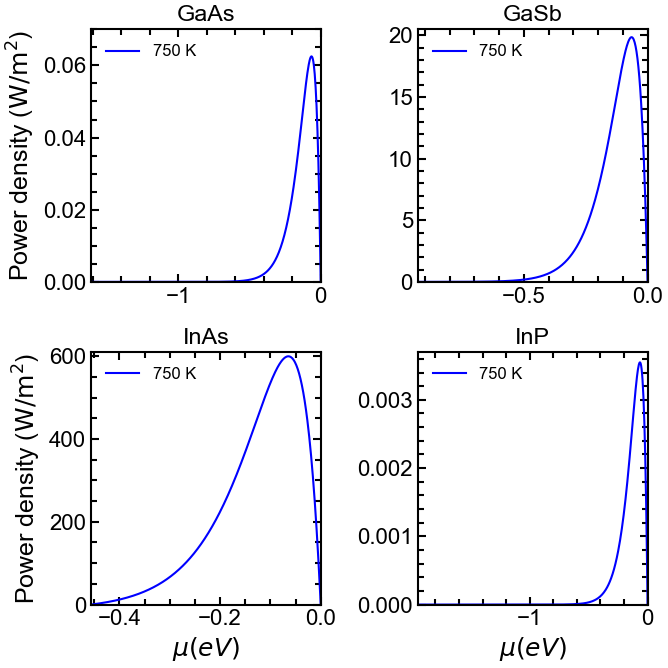

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7,7))

# ----------------------------------#
# plot GaAs
# ----------------------------------#
axes[0,0].plot(muListGaAs750, PowerDensityGaAs750, 'b-', label='750 K')
# X-axis
#axes[0,0].set_xlabel(r'$\mu (eV)$')
axes[0,0].set_xlim(muVOCGaAs750, 0.0)
# Y-axis
axes[0,0].set_ylabel('Power density ($\mathrm{W/m}^2$)')
axes[0,0].set_ylim(0.0, 0.07)
axes[0,0].legend(loc='best', prop={'size': 12})
axes[0,0].set_title(r'GaAs')

# ----------------------------------#
# plot GaSb
# ----------------------------------#
axes[0,1].plot(muListGaSb750, PowerDensityGaSb750, 'b-', label='750 K')
# X-axis
#axes[0,1].set_xlabel(r'$\mu (eV)$')
axes[0,1].set_xlim(muVOCGaSb750, 0.0)
# Y-axis
#axes[0,1].set_ylabel('Power density ($\mathrm{W/m}^2$)')
axes[0,1].set_ylim(0.0, 20.5)
axes[0,1].legend(loc='best', prop={'size': 12})
axes[0,1].set_title(r'GaSb')

# ----------------------------------#
# plot InAs
# ----------------------------------#
axes[1,0].plot(muListInAs750, PowerDensityInAs750, 'b-', label='750 K')
# X-axis
axes[1,0].set_xlabel(r'$\mu (eV)$')
axes[1,0].set_xlim(muVOCInAs750, 0.0)
# Y-axis
axes[1,0].set_ylabel('Power density ($\mathrm{W/m}^2$)')
axes[1,0].set_ylim(0.0, 610)
axes[1,0].legend(loc='best', prop={'size': 12})
axes[1,0].set_title(r'InAs')

# ----------------------------------#
# plot InP
# ----------------------------------#
axes[1,1].plot(muListInP750, PowerDensityInP750, 'b-', label='750 K')
# X-axis
axes[1,1].set_xlabel(r'$\mu (eV)$')
axes[1,1].set_xlim(muVOCInP750, 0.0)
# Y-axis
#axes[1,1].set_ylabel('Power density ($\mathrm{W/m}^2$)')
axes[1,1].set_ylim(0.0, 0.0037)
axes[1,1].legend(loc='best', prop={'size': 12})
axes[1,1].set_title(r'InP')

plt.tight_layout()

# save figure
fig.savefig('./imag/PowerDensity750.svg')

plt.show()

## Efficiency without losses ($T_{c} = 750$ K)

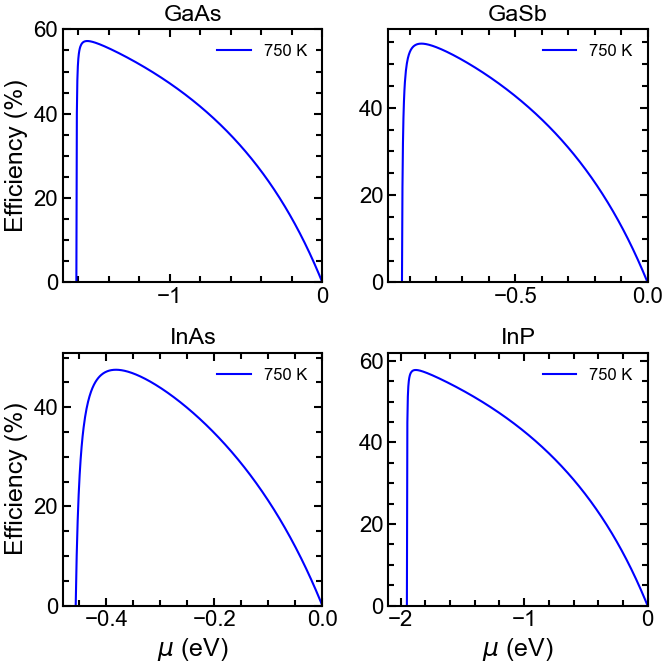

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7,7))

# ----------------------------------#
# plot GaAs
# ----------------------------------#
axes[0,0].plot(muListGaAs750, EfficiencyWithOutLossesGaAs750*100, 'b-', label='750 K')
# X-axis
axes[0,0].set_xlim(-1.7, 0.0)
# Y-axis
axes[0,0].set_ylabel('Efficiency (%)')
axes[0,0].set_ylim(0.0, 60.0)
axes[0,0].legend(loc='best', prop={'size': 12})
axes[0,0].set_title(r'GaAs')

# ----------------------------------#
# plot GaSb
# ----------------------------------#
axes[0,1].plot(muListGaSb750, EfficiencyWithOutLossesGaSb750*100, 'b-', label='750 K')
# X-axis
axes[0,1].set_xlim(-0.98, 0.0)
# Y-axis
axes[0,1].set_ylim(0.0, 58.0)
axes[0,1].legend(loc='best', prop={'size': 12})
axes[0,1].set_title(r'GaSb')

# ----------------------------------#
# plot InAs
# ----------------------------------#
axes[1,0].plot(muListInAs750, EfficiencyWithOutLossesInAs750*100, 'b-', label='750 K')
# X-axis
axes[1,0].set_xlabel(r'$\mu$ (eV)')
axes[1,0].set_xlim(-0.48, 0.0)
# Y-axis
axes[1,0].set_ylabel('Efficiency (%)')
axes[1,0].set_ylim(0.0, 51.0)
axes[1,0].legend(loc='best', prop={'size': 12})
axes[1,0].set_title(r'InAs')

# ----------------------------------#
# plot InP
# ----------------------------------#
axes[1,1].plot(muListInP750, EfficiencyWithOutLossesInP750*100, 'b-', label='750 K')
# X-axis
axes[1,1].set_xlabel(r'$\mu$ (eV)')
axes[1,1].set_xlim(-2.1, 0.0)
# Y-axis
axes[1,1].set_ylim(0.0, 62.0)
axes[1,1].legend(loc='best', prop={'size': 12})
axes[1,1].set_title(r'InP')

plt.tight_layout()

# save figure
fig.savefig('./imag/EfficiencyWOLosses750.svg')

plt.show()

## Efficiency with sub-bandgap losses ($T_{c} = 750$ K)

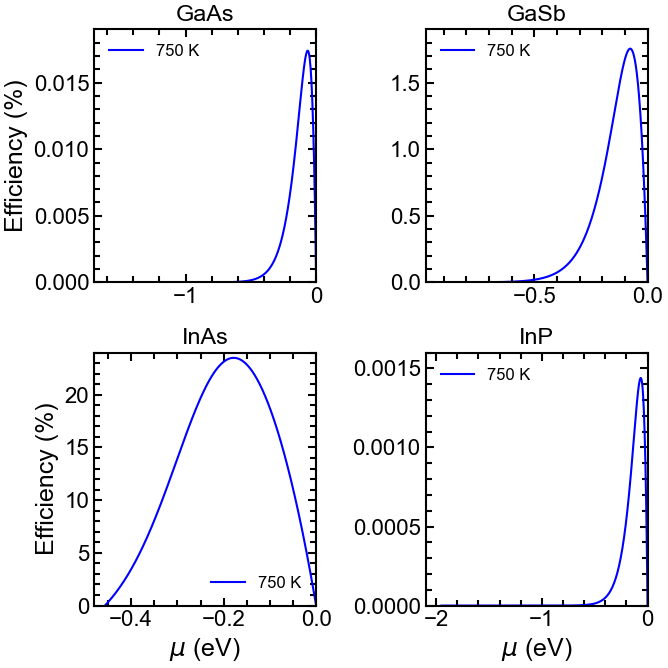

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7,7))

# ----------------------------------#
# plot GaAs
# ----------------------------------#
axes[0,0].plot(muListGaAs750, EfficiencywithSubBandGapLossesGaAs750*100, 'b-', label='750 K')
# X-axis
axes[0,0].set_xlim(-1.7, 0.0)
# Y-axis
axes[0,0].set_ylabel('Efficiency (%)')
axes[0,0].set_ylim(0.0, 0.019)
axes[0,0].legend(loc='best', prop={'size': 12})
axes[0,0].set_title(r'GaAs')

# ----------------------------------#
# plot GaSb
# ----------------------------------#
axes[0,1].plot(muListGaSb750, EfficiencywithSubBandGapLossesGaSb750*100, 'b-', label='750 K')
# X-axis
axes[0,1].set_xlim(-0.98, 0.0)
# Y-axis
axes[0,1].set_ylim(0.0, 1.9)
axes[0,1].legend(loc='best', prop={'size': 12})
axes[0,1].set_title(r'GaSb')

# ----------------------------------#
# plot InAs
# ----------------------------------#
axes[1,0].plot(muListInAs750, EfficiencywithSubBandGapLossesInAs750*100, 'b-', label='750 K')
# X-axis
axes[1,0].set_xlabel(r'$\mu$ (eV)')
axes[1,0].set_xlim(-0.48, 0.0)
# Y-axis
axes[1,0].set_ylabel('Efficiency (%)')
axes[1,0].set_ylim(0.0, 24.0)
axes[1,0].legend(loc='best', prop={'size': 12})
axes[1,0].set_title(r'InAs')

# ----------------------------------#
# plot InP
# ----------------------------------#
axes[1,1].plot(muListInP750, EfficiencywithSubBandGapLossesInP750*100, 'b-', label='750 K')
# X-axis
axes[1,1].set_xlabel(r'$\mu$ (eV)')
axes[1,1].set_xlim(-2.1, 0.0)
# Y-axis
axes[1,1].set_ylim(0.0, 0.0016)
axes[1,1].legend(loc='best', prop={'size': 12})
axes[1,1].set_title(r'InP')

plt.tight_layout()

# save figure
fig.savefig('./imag/EfficiencyWLosses750.svg')

plt.show()

## Summary

In [19]:
# determine maximum power density
## GaAs
MaxPowerDensityGaAs500 = np.max(PowerDensityGaAs500)
MaxPowerDensityGaAs750 = np.max(PowerDensityGaAs750)
MaxPowerDensityGaAs1000 = np.max(PowerDensityGaAs1000)
## GaSb
MaxPowerDensityGaSb500 = np.max(PowerDensityGaSb500)
MaxPowerDensityGaSb750 = np.max(PowerDensityGaSb750)
MaxPowerDensityGaSb1000 = np.max(PowerDensityGaSb1000)
## InAs
MaxPowerDensityInAs500 = np.max(PowerDensityInAs500)
MaxPowerDensityInAs750 = np.max(PowerDensityInAs750)
MaxPowerDensityInAs1000 = np.max(PowerDensityInAs1000)
## InP
MaxPowerDensityInP500 = np.max(PowerDensityInP500)
MaxPowerDensityInP750 = np.max(PowerDensityInP750)
MaxPowerDensityInP1000 = np.max(PowerDensityInP1000)

# determine maximum efficiency without losses
## GaAs
MaxEfficiencyWithOutLossesGaAs500 = np.max(EfficiencyWithOutLossesGaAs500*100)
MaxEfficiencyWithOutLossesGaAs750 = np.max(EfficiencyWithOutLossesGaAs750*100)
MaxEfficiencyWithOutLossesGaAs1000 = np.max(EfficiencyWithOutLossesGaAs1000*100)
## GaSb
MaxEfficiencyWithOutLossesGaSb500 = np.max(EfficiencyWithOutLossesGaSb500*100)
MaxEfficiencyWithOutLossesGaSb750 = np.max(EfficiencyWithOutLossesGaSb750*100)
MaxEfficiencyWithOutLossesGaSb1000 = np.max(EfficiencyWithOutLossesGaSb1000*100)
## InAs
MaxEfficiencyWithOutLossesInAs500 = np.max(EfficiencyWithOutLossesInAs500*100)
MaxEfficiencyWithOutLossesInAs750 = np.max(EfficiencyWithOutLossesInAs750*100)
MaxEfficiencyWithOutLossesInAs1000 = np.max(EfficiencyWithOutLossesInAs1000*100)
## InP
MaxEfficiencyWithOutLossesInP500 = np.max(EfficiencyWithOutLossesInP500*100)
MaxEfficiencyWithOutLossesInP750 = np.max(EfficiencyWithOutLossesInP750*100)
MaxEfficiencyWithOutLossesInP1000 = np.max(EfficiencyWithOutLossesInP1000*100)

# determine maximum efficiency with losses
## GaAs
MaxEfficiencyWithLossesGaAs500 = np.max(EfficiencywithSubBandGapLossesGaAs500*100)
MaxEfficiencyWithLossesGaAs750 = np.max(EfficiencywithSubBandGapLossesGaAs750*100)
MaxEfficiencyWithLossesGaAs1000 = np.max(EfficiencywithSubBandGapLossesGaAs1000*100)
## GaSb
MaxEfficiencyWithLossesGaSb500 = np.max(EfficiencywithSubBandGapLossesGaSb500*100)
MaxEfficiencyWithLossesGaSb750 = np.max(EfficiencywithSubBandGapLossesGaSb750*100)
MaxEfficiencyWithLossesGaSb1000 = np.max(EfficiencywithSubBandGapLossesGaSb1000*100)
## InAs
MaxEfficiencyWithLossesInAs500 = np.max(EfficiencywithSubBandGapLossesInAs500*100)
MaxEfficiencyWithLossesInAs750 = np.max(EfficiencywithSubBandGapLossesInAs750*100)
MaxEfficiencyWithLossesInAs1000 = np.max(EfficiencywithSubBandGapLossesInAs1000*100)
## InP
MaxEfficiencyWithLossesInP500 = np.max(EfficiencywithSubBandGapLossesInP500*100)
MaxEfficiencyWithLossesInP750 = np.max(EfficiencywithSubBandGapLossesInP750*100)
MaxEfficiencyWithLossesInP1000 = np.max(EfficiencywithSubBandGapLossesInP1000*100)

In [20]:
# print all summary result
print('#---------------------------#')
print('# GaAs (Eg = {} eV)'.format(EgapGaAs))
print('#---------------------------#')
print('P_max ({} K) = {:.6f} W/m^2'.format(Tcell[0], MaxPowerDensityGaAs500))
print('P_max ({} K) = {:.6f} W/m^2'.format(Tcell[1], MaxPowerDensityGaAs750))
print('P_max ({} K) = {:.6f} W/m^2'.format(Tcell[2], MaxPowerDensityGaAs1000))
print('')
print('eta_max w/o losses ({} K) = {:.5f} %'.format(Tcell[0], MaxEfficiencyWithOutLossesGaAs500))
print('eta_max w/o losses ({} K) = {:.5f} %'.format(Tcell[1], MaxEfficiencyWithOutLossesGaAs750))
print('eta_max w/o losses ({} K) = {:.5f} %'.format(Tcell[2], MaxEfficiencyWithOutLossesGaAs1000))
print('')
print('eta_max w losses ({} K) = {:.6f} %'.format(Tcell[0], MaxEfficiencyWithLossesGaAs500))
print('eta_max w losses ({} K) = {:.6f} %'.format(Tcell[1], MaxEfficiencyWithLossesGaAs750))
print('eta_max w losses ({} K) = {:.6f} %'.format(Tcell[2], MaxEfficiencyWithLossesGaAs1000))
print('#---------------------------#')
print('')
print('#---------------------------#')
print('# GaSb (Eg = {} eV)'.format(EgapGaSb))
print('#---------------------------#')
print('P_max ({} K) = {:.6f} W/m^2'.format(Tcell[0], MaxPowerDensityGaSb500))
print('P_max ({} K) = {:.6f} W/m^2'.format(Tcell[1], MaxPowerDensityGaSb750))
print('P_max ({} K) = {:.6f} W/m^2'.format(Tcell[2], MaxPowerDensityGaSb1000))
print('')
print('eta_max w/o losses ({} K) = {:.5f} %'.format(Tcell[0], MaxEfficiencyWithOutLossesGaSb500))
print('eta_max w/o losses ({} K) = {:.5f} %'.format(Tcell[1], MaxEfficiencyWithOutLossesGaSb750))
print('eta_max w/o losses ({} K) = {:.5f} %'.format(Tcell[2], MaxEfficiencyWithOutLossesGaSb1000))
print('')
print('eta_max w losses ({} K) = {:.6f} %'.format(Tcell[0], MaxEfficiencyWithLossesGaSb500))
print('eta_max w losses ({} K) = {:.6f} %'.format(Tcell[1], MaxEfficiencyWithLossesGaSb750))
print('eta_max w losses ({} K) = {:.6f} %'.format(Tcell[2], MaxEfficiencyWithLossesGaSb1000))
print('#---------------------------#')
print('')
print('#---------------------------#')
print('# InAs (Eg = {} eV)'.format(EgapInAs))
print('#---------------------------#')
print('P_max ({} K) = {:.6f} W/m^2'.format(Tcell[0], MaxPowerDensityInAs500))
print('P_max ({} K) = {:.6f} W/m^2'.format(Tcell[1], MaxPowerDensityInAs750))
print('P_max ({} K) = {:.6f} W/m^2'.format(Tcell[2], MaxPowerDensityInAs1000))
print('')
print('eta_max w/o losses ({} K) = {:.5f} %'.format(Tcell[0], MaxEfficiencyWithOutLossesInAs500))
print('eta_max w/o losses ({} K) = {:.5f} %'.format(Tcell[1], MaxEfficiencyWithOutLossesInAs750))
print('eta_max w/o losses ({} K) = {:.5f} %'.format(Tcell[2], MaxEfficiencyWithOutLossesInAs1000))
print('')
print('eta_max w losses ({} K) = {:.6f} %'.format(Tcell[0], MaxEfficiencyWithLossesInAs500))
print('eta_max w losses ({} K) = {:.6f} %'.format(Tcell[1], MaxEfficiencyWithLossesInAs750))
print('eta_max w losses ({} K) = {:.6f} %'.format(Tcell[2], MaxEfficiencyWithLossesInAs1000))
print('#---------------------------#')
print('')
print('#---------------------------#')
print('# InP (Eg = {} eV)'.format(EgapInP))
print('#---------------------------#')
print('P_max ({} K) = {:.6f} W/m^2'.format(Tcell[0], MaxPowerDensityInP500))
print('P_max ({} K) = {:.6f} W/m^2'.format(Tcell[1], MaxPowerDensityInP750))
print('P_max ({} K) = {:.6f} W/m^2'.format(Tcell[2], MaxPowerDensityInP1000))
print('')
print('eta_max w/o losses ({} K) = {:.5f} %'.format(Tcell[0], MaxEfficiencyWithOutLossesInP500))
print('eta_max w/o losses ({} K) = {:.5f} %'.format(Tcell[1], MaxEfficiencyWithOutLossesInP750))
print('eta_max w/o losses ({} K) = {:.5f} %'.format(Tcell[2], MaxEfficiencyWithOutLossesInP1000))
print('')
print('eta_max w losses ({} K) = {:.7f} %'.format(Tcell[0], MaxEfficiencyWithLossesInP500))
print('eta_max w losses ({} K) = {:.6f} %'.format(Tcell[1], MaxEfficiencyWithLossesInP750))
print('eta_max w losses ({} K) = {:.6f} %'.format(Tcell[2], MaxEfficiencyWithLossesInP1000))
print('#---------------------------#')
print('')

#---------------------------#
# GaAs (Eg = 1.016 eV)
#---------------------------#
P_max (500.0 K) = 0.000009 W/m^2
P_max (750.0 K) = 0.062506 W/m^2
P_max (1000.0 K) = 6.844043 W/m^2

eta_max w/o losses (500.0 K) = 38.06307 %
eta_max w/o losses (750.0 K) = 57.23028 %
eta_max w/o losses (1000.0 K) = 66.75389 %

eta_max w losses (500.0 K) = 0.000030 %
eta_max w losses (750.0 K) = 0.017398 %
eta_max w losses (1000.0 K) = 0.306166 %
#---------------------------#

#---------------------------#
# GaSb (Eg = 0.554 eV)
#---------------------------#
P_max (500.0 K) = 0.090787 W/m^2
P_max (750.0 K) = 19.861765 W/m^2
P_max (1000.0 K) = 391.031241 W/m^2

eta_max w/o losses (500.0 K) = 36.37975 %
eta_max w/o losses (750.0 K) = 54.72361 %
eta_max w/o losses (1000.0 K) = 63.62587 %

eta_max w losses (500.0 K) = 0.110770 %
eta_max w losses (750.0 K) = 1.754867 %
eta_max w losses (1000.0 K) = 5.571785 %
#---------------------------#

#---------------------------#
# InAs (Eg = 0.209 eV)
#---------------